In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
 
import cv2
import os
from os import listdir
import re
import gc
import sys
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm import tqdm
from pprint import pprint
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob

from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

# Models

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

**Load data**

In [3]:
# Load dataframes
##get metadata created dataset.
train_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
train_bbox = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")

# Print dataframe shapes
print('train shape:', train_df.shape)
print('train bbox shape:', train_bbox.shape)
print('')

# Show first few entries
train_df.head(3)

train shape: (2019, 9)
train bbox shape: (7217, 6)



,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0


In [4]:
# Store segmentation paths in a dataframe
base_path = "../input/rsna-2022-cervical-spine-fracture-detection"
seg_paths = glob(f"{base_path}/segmentations/*")
seg_df = pd.DataFrame({'path': seg_paths})
seg_df['StudyInstanceUID'] = seg_df['path'].apply(lambda x:x.split('/')[-1][:-4])
seg_df = seg_df[['StudyInstanceUID','path']]
print('seg_df shape:', seg_df.shape)
seg_df.head(3)

seg_df shape: (87, 2)


,StudyInstanceUID,path
0,1.2.826.0.1.3680043.780,../input/rsna-2022-cervical-spine-fracture-det...
1,1.2.826.0.1.3680043.21321,../input/rsna-2022-cervical-spine-fracture-det...
2,1.2.826.0.1.3680043.6125,../input/rsna-2022-cervical-spine-fracture-det...


In [5]:
# import metada dataset
meta_train = pd.read_csv("../input/rsna-2022-spine-fracture-detection-metadata/meta_train_clean.csv")

# Only select patients with segmentations
meta_seg = meta_train[meta_train['StudyInstanceUID'].isin(seg_df['StudyInstanceUID'])].reset_index(drop=True)
print('meta_seg shape:', meta_seg.shape)
meta_seg.head(3)

meta_seg shape: (29832, 8)


,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z
0,1.2.826.0.1.3680043.10633,1,512,512,1.0,-68.0,98.0,314.099976
1,1.2.826.0.1.3680043.10633,2,512,512,1.0,-68.0,98.0,313.599976
2,1.2.826.0.1.3680043.10633,3,512,512,1.0,-68.0,98.0,313.099976


**Example**

In [6]:
# Example
ex_path = "../input/rsna-2022-cervical-spine-fracture-detection/segmentations/1.2.826.0.1.3680043.12281.nii"
example = nib.load(ex_path)
example = example.get_fdata()  # convert to numpy array
example = example[:, ::-1, ::-1].transpose(2, 1, 0)  # align orientation with train image
np.unique(example[119])

array([0., 2.])

Interpretation:
* 0 ---> background 
* 2 ---> C2

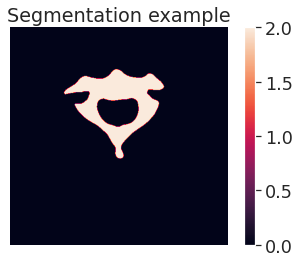

In [7]:
plt.figure()
plt.imshow(example[119])
plt.title('Segmentation example')
plt.colorbar()
plt.axis('off')
plt.show()

**Extract vertebrae from segmentations**

In [9]:
# Initialise targets
targets = ['C1','C2','C3','C4','C5','C6','C7']
meta_seg[targets]=0
meta_seg

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10633,1,512,512,1.0,-68.000000,98.000000,314.099976,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10633,2,512,512,1.0,-68.000000,98.000000,313.599976,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10633,3,512,512,1.0,-68.000000,98.000000,313.099976,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10633,4,512,512,1.0,-68.000000,98.000000,312.599976,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.10633,5,512,512,1.0,-68.000000,98.000000,312.099976,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29827,1.2.826.0.1.3680043.9926,166,512,512,1.0,-100.824219,-209.824219,130.400000,0,0,0,0,0,0,0
29828,1.2.826.0.1.3680043.9926,167,512,512,1.0,-100.824219,-209.824219,129.400000,0,0,0,0,0,0,0
29829,1.2.826.0.1.3680043.9926,168,512,512,1.0,-100.824219,-209.824219,128.400000,0,0,0,0,0,0,0
29830,1.2.826.0.1.3680043.9926,169,512,512,1.0,-100.824219,-209.824219,127.400000,0,0,0,0,0,0,0


In [10]:
meta_seg = pd.read_csv('../input/rsna-2022-spine-fracture-detection-metadata/meta_segmentation.csv')
meta_seg.head(3)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10633,1,512,512,1.0,-68.0,98.0,314.099976,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10633,2,512,512,1.0,-68.0,98.0,313.599976,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10633,3,512,512,1.0,-68.0,98.0,313.099976,0,0,0,0,0,0,0


**Examples**

In [11]:
# Example
meta_seg[['StudyInstanceUID','Slice']+targets].iloc[199:204,:]

,StudyInstanceUID,Slice,C1,C2,C3,C4,C5,C6,C7
199,1.2.826.0.1.3680043.10633,200,0,1,1,0,0,0,0
200,1.2.826.0.1.3680043.10633,201,0,1,1,0,0,0,0
201,1.2.826.0.1.3680043.10633,202,0,0,1,1,0,0,0
202,1.2.826.0.1.3680043.10633,203,0,0,1,1,0,0,0
203,1.2.826.0.1.3680043.10633,204,0,0,1,1,0,0,0


In [12]:
# Print example of extracted vertebrae
print('UID:', meta_seg['StudyInstanceUID'].unique()[0])
pd.set_option('display.max_rows', 500)
meta_seg[meta_seg['StudyInstanceUID']==meta_seg['StudyInstanceUID'].unique()[0]].loc[110:340,targets]

UID: 1.2.826.0.1.3680043.10633


,C1,C2,C3,C4,C5,C6,C7
110,0,0,0,0,0,0,0
111,1,0,0,0,0,0,0
112,1,0,0,0,0,0,0
113,1,0,0,0,0,0,0
114,1,0,0,0,0,0,0
115,1,0,0,0,0,0,0
116,1,0,0,0,0,0,0
117,1,0,0,0,0,0,0
118,1,0,0,0,0,0,0
119,1,0,0,0,0,0,0


<hr>

In [13]:
# Calculate slice ratio (to generalise better)
slice_max_seg = meta_seg.groupby('StudyInstanceUID')['Slice'].max().to_dict()
meta_seg['SliceRatio'] = 0
meta_seg['SliceRatio'] = meta_seg['Slice']/meta_seg['StudyInstanceUID'].map(slice_max_seg)

In [15]:
##using metadata for run a simple classifier
features = ['SliceRatio','SliceThickness','ImagePositionPatient_x','ImagePositionPatient_y','ImagePositionPatient_z']
# Features and targets
X = meta_seg[['StudyInstanceUID']+features]
y = meta_seg[targets]

In [16]:
# Train-valid split, grouped by patient (80/20 split)
gkf = GroupKFold(n_splits=5)
(train_idx, valid_idx) = next(gkf.split(X, y, groups = X['StudyInstanceUID']))

# Train set
X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx,:]

# Validation set
X_valid, y_valid = X.iloc[valid_idx,:], y.iloc[valid_idx,:]

# Drop patient id
X_train = X_train.drop('StudyInstanceUID', axis=1)
X_valid = X_valid.drop('StudyInstanceUID', axis=1)

In [17]:
# Train classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [18]:
# Evaluate model
y_preds = clf.predict(X_valid)

total_acc = 0 
for i in range(7):
    acc = (y_valid[f'C{i+1}']==y_preds[:,i]).sum()/len(y_preds[:,i])
    total_acc+=acc/7
    print(f'Accuracy of C{i+1}: {acc} %')

print('')
print(f'Overall accuracy: {total_acc} %')

Accuracy of C1: 0.8937468225724453 %
Accuracy of C2: 0.8818844263684121 %
Accuracy of C3: 0.8995085578715472 %
Accuracy of C4: 0.8940857481782749 %
Accuracy of C5: 0.8908659549228944 %
Accuracy of C6: 0.8751059142518217 %
Accuracy of C7: 0.8556176919166243 %

Overall accuracy: 0.8844021594402885 %


In [19]:
# Feature importances
pd.DataFrame({'Feature':features, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False)

,Feature,Importance
0,SliceRatio,0.575716
4,ImagePositionPatient_z,0.211188
3,ImagePositionPatient_y,0.089846
2,ImagePositionPatient_x,0.089661
1,SliceThickness,0.033589


In [21]:
preds = clf.predict(X_valid)


In [23]:
np.set_printoptions(threshold=np.inf)
clf.predict(X.drop('StudyInstanceUID',axis=1))[110:250,:]

array([[1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1,

**Predict vertebrae numbers on entire train set**

In [25]:
# Read in metadata for entire train set
meta_train = pd.read_csv('../input/rsna-2022-spine-fracture-detection-metadata/meta_train_clean.csv')

# Calculate slice ratio (to generalise better)
slice_max_train = meta_train.groupby('StudyInstanceUID')['Slice'].max().to_dict()
meta_train['SliceRatio'] = 0
meta_train['SliceRatio'] = meta_train['Slice']/meta_train['StudyInstanceUID'].map(slice_max_train)

# Initialise targets
meta_train[targets]=0

# Predict targets for entire train set
meta_train[targets] = clf.predict(meta_train[features])

# We know images with segmentations have 100% accurate targets so put these back in
meta_train.loc[meta_train['StudyInstanceUID'].isin(meta_seg['StudyInstanceUID']),targets] = meta_seg[targets].values

 

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,SliceRatio,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282,0.003731,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657,0.007463,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032,0.011194,0,0,0,0,0,0,0


In [41]:
pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1
2015,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1
2016,1.2.826.0.1.3680043.14341,0,0,0,0,0,0,0,0
2017,1.2.826.0.1.3680043.12053,0,0,0,0,0,0,0,0


In [43]:
meta_df=meta_train[['StudyInstanceUID',"Slice"]+targets]
tr_df=meta_train[['StudyInstanceUID',"Slice"]+targets].groupby("StudyInstanceUID").first().reset_index()

In [45]:
tr_df.to_csv("grouped_tr_df.csv",index=False)

,StudyInstanceUID,Slice,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10005,1,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10014,1,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10016,1,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.10032,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.9926,1,0,0,0,0,0,0,0
2015,1.2.826.0.1.3680043.9940,1,0,0,0,0,0,0,0
2016,1.2.826.0.1.3680043.9994,1,0,0,0,0,0,0,0
2017,1.2.826.0.1.3680043.9996,1,0,0,0,0,0,0,0


In [44]:
meta_df.to_csv("all_slices_data.csv", index=False)

,StudyInstanceUID,Slice,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10001,2,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10001,3,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10001,4,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.10001,5,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
711596,1.2.826.0.1.3680043.9997,251,0,0,0,0,0,0,0
711597,1.2.826.0.1.3680043.9997,252,0,0,0,0,0,0,0
711598,1.2.826.0.1.3680043.9997,253,0,0,0,0,0,0,0
711599,1.2.826.0.1.3680043.9997,254,0,0,0,0,0,0,0
